# Building Age data

In [47]:
from text_encoder import get_encode_fn
from pcd_to_geopandas import load_pcd_and_features, convert_to_lat_lon, coord_to_geopandas, aggregate_by_region
from visualization_utils import visualize
import numpy as np
import os
import requests
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer

In [48]:
data_dir = "../data/"

In [49]:
# URL to get capabilities
capabilities_url = "https://data.3dbag.nl/api/BAG3D/wfs?service=WFS&version=2.0.0&request=GetCapabilities"

# Make the request
response = requests.get(capabilities_url)

# Check if the request was successful
if response.status_code == 200:
    # Save the capabilities XML data to a file
    with open("capabilities.xml", "wb") as file:
        file.write(response.content)
    print("Capabilities XML data saved to capabilities.xml")
else:
    print(f"Failed to get capabilities: {response.status_code}")


Capabilities XML data saved to capabilities.xml


In [50]:

# URL and parameters for the GetFeature request
wfs_url = "https://data.3dbag.nl/api/BAG3D/wfs"

epsilon = .0
nw_lat, nw_lon = 51.91942+epsilon, 4.45423-epsilon  # Top-left (northwest)
se_lat, se_lon = 51.90880 -epsilon, 4.47410+epsilon  # Bottom-right (southeast)

#min_x_rotterdam, min_y_rotterdam = nw_lon, se_lat
#max_x_rotterdam, max_y_rotterdam = se_lon, nw_lat

transformer = Transformer.from_crs("epsg:4326", "EPSG:28992")
min_x_rotterdam, max_y_rotterdam = transformer.transform(nw_lat, nw_lon)
max_x_rotterdam, min_y_rotterdam = transformer.transform(se_lat, se_lon)



rounding_len = 5
min_x_rotterdam= round(min_x_rotterdam, rounding_len)
max_x_rotterdam= round(max_x_rotterdam, rounding_len)
min_y_rotterdam= round(min_y_rotterdam, rounding_len)
max_y_rotterdam= round(max_y_rotterdam, rounding_len)

'''
min_x_rotterdam= 100000
max_x_rotterdam= 200000
min_y_rotterdam= 300000
max_y_rotterdam= 400000
'''
print(f"coordinates: {min_x_rotterdam}, {max_x_rotterdam}, {min_y_rotterdam}, {max_y_rotterdam}")

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typeName": "BAG3D:lod12",  # You can change this to any other available typeName
    "outputFormat": "application/json",
    "bbox": f"{min_x_rotterdam},{min_y_rotterdam},{max_x_rotterdam},{max_y_rotterdam}"  # Bounding box for Rotterdam
}

# Make the request
response = requests.get(wfs_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Save the GeoJSON data to a file
    with open(os.path.join(data_dir, "rotterdam.geojson"), "w") as file:
        file.write(response.text)
    print("GeoJSON data saved to rotterdam_lod12.geojson")
else:
    print(f"Failed to get data: {response.status_code}")



# Check if the response was successful
if response.status_code == 200:
    # Parse the GeoJSON response
    data = response.json()
    
    # Check if data is loaded correctly
    print("GeoJSON data loaded successfully")
else:
    print("Error loading GeoJSON data: ", response.status_code)
    data = None


coordinates: 90816.99453, 92169.03989, 435983.63129, 437182.46772
GeoJSON data saved to rotterdam_lod12.geojson
GeoJSON data loaded successfully


In [51]:
'''
# dont use
import numpy as np
import requests
import json
import datetime
#
# URL of the WFS service endpoint


# Define a function to calculate building age
def calculate_building_age(properties):
    current_year = datetime.datetime.now().year
    bouwjaar = properties.get('oorspronkelijkbouwjaar', current_year)
    building_age = current_year - bouwjaar
    return building_age

# Initialize a list to store building ages and coordinates
building_data = []

# Process the GeoJSON data
if data:
    try:
        features = data['features']
        for feature in features:
            properties = feature['properties']
            geometry = feature['geometry']
            building_age = calculate_building_age(properties)
            
            if geometry['type'] == 'Polygon':
                # Get the centroid of the polygon
                coordinates = np.array(geometry['coordinates'][0])
                print(len(coordinates))
                centroid = np.mean(coordinates, axis=0)
                building_data.append((centroid[0], centroid[1], building_age))
        
        print("Building data processed successfully")
    except Exception as e:
        print("Error processing GeoJSON data: ", str(e))


# Convert building data to a NumPy array
building_array = np.array(building_data, dtype=[('x', 'f4'), ('y', 'f4'), ('age', 'i4')])

# Save the array to a .npz file
np.savez('building_ages.npz', building_array=building_array)
print("Building ages saved to building_ages.npz")
'''


'\n# dont use\nimport numpy as np\nimport requests\nimport json\nimport datetime\n#\n# URL of the WFS service endpoint\n\n\n# Define a function to calculate building age\ndef calculate_building_age(properties):\n    current_year = datetime.datetime.now().year\n    bouwjaar = properties.get(\'oorspronkelijkbouwjaar\', current_year)\n    building_age = current_year - bouwjaar\n    return building_age\n\n# Initialize a list to store building ages and coordinates\nbuilding_data = []\n\n# Process the GeoJSON data\nif data:\n    try:\n        features = data[\'features\']\n        for feature in features:\n            properties = feature[\'properties\']\n            geometry = feature[\'geometry\']\n            building_age = calculate_building_age(properties)\n            \n            if geometry[\'type\'] == \'Polygon\':\n                # Get the centroid of the polygon\n                coordinates = np.array(geometry[\'coordinates\'][0])\n                print(len(coordinates))\n      

In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
gdf = gpd.read_file(os.path.join(data_dir,"rotterdam.geojson"))
gdf.head()

,id,fid,b3_dd_id,identificatie,b3_pand_deel_id,b3_h_50p,b3_h_70p,b3_h_max,b3_h_min,b3_bag_bag_overlap,...,oorspronkelijkbouwjaar,status,tijdstipeindregistratielv,tijdstipinactief,tijdstipinactieflv,tijdstipnietbaglv,tijdstipregistratie,tijdstipregistratielv,voorkomenidentificatie,geometry
0,lod12.5793972,5793972,0,NL.IMBAG.Pand.0599100000639499,0,9.331596,9.595734,10.474796,6.963517,0.0,...,1903,Pand in gebruik,None,None,None,None,2015-10-12 13:46:47+00:00,2015-10-12 14:00:28+00:00,2,"POLYGON ((91086.438 436800.312, 91074.695 4368..."
1,lod12.5794463,5794463,0,NL.IMBAG.Pand.0599100000672092,0,12.400835,13.255198,14.352334,10.249964,0.0,...,1902,Pand in gebruik,None,None,None,None,2015-10-16 16:19:34+00:00,2015-10-16 16:30:12+00:00,2,"POLYGON ((91132.867 436744.500, 91126.891 4367..."
2,lod12.5804853,5804853,0,NL.IMBAG.Pand.0599100000650793,0,11.477911,13.633970,14.141188,2.810651,0.0,...,1984,Pand in gebruik,None,None,None,None,2015-10-17 11:38:55+00:00,2015-10-17 12:00:07+00:00,2,"POLYGON ((92179.625 437101.406, 92178.805 4371..."
3,lod12.5794080,5794080,0,NL.IMBAG.Pand.0599100000761577,0,12.339454,12.351391,12.369716,8.885713,0.0,...,1991,Pand in gebruik,None,None,None,None,2015-10-16 23:02:43+00:00,2015-10-16 23:30:06+00:00,2,"POLYGON ((91089.055 436320.625, 91093.070 4363..."
4,lod12.5794852,5794852,0,NL.IMBAG.Pand.0599100000670155,0,12.103424,12.669908,13.142063,8.699863,0.0,...,1895,Pand in gebruik,None,None,None,None,2016-07-13 11:15:19+00:00,2016-07-13 11:30:59+00:00,3,"POLYGON ((91558.594 436519.156, 91572.844 4365..."


In [53]:
gdf.columns

Index(['id', 'fid', 'b3_dd_id', 'identificatie', 'b3_pand_deel_id', 'b3_h_50p',
       'b3_h_70p', 'b3_h_max', 'b3_h_min', 'b3_bag_bag_overlap', 'b3_dak_type',
       'b3_h_maaiveld', 'b3_kas_warenhuis', 'b3_mutatie_ahn3_ahn4',
       'b3_nodata_fractie_ahn3', 'b3_nodata_fractie_ahn4',
       'b3_nodata_radius_ahn3', 'b3_nodata_radius_ahn4', 'b3_opp_buitenmuur',
       'b3_opp_dak_plat', 'b3_opp_dak_schuin', 'b3_opp_grond',
       'b3_opp_scheidingsmuur', 'b3_puntdichtheid_ahn3',
       'b3_puntdichtheid_ahn4', 'b3_pw_bron', 'b3_pw_datum',
       'b3_pw_selectie_reden', 'b3_reconstructie_onvolledig', 'b3_rmse_lod12',
       'b3_rmse_lod13', 'b3_rmse_lod22', 'b3_val3dity_lod12',
       'b3_val3dity_lod13', 'b3_val3dity_lod22', 'b3_volume_lod12',
       'b3_volume_lod13', 'b3_volume_lod22', 'b3_bouwlagen',
       'b3_kwaliteitsindicator', 'begingeldigheid', 'documentdatum',
       'documentnummer', 'eindgeldigheid', 'eindregistratie', 'geconstateerd',
       'oorspronkelijkbouwjaar', 'st

In [54]:
print(gdf['status'].unique())


['Pand in gebruik' 'Verbouwing pand' 'Sloopvergunning verleend']


In [55]:
buildings_gdf = gdf[gdf['status'] == 'Pand in gebruik']
len(buildings_gdf)

3067

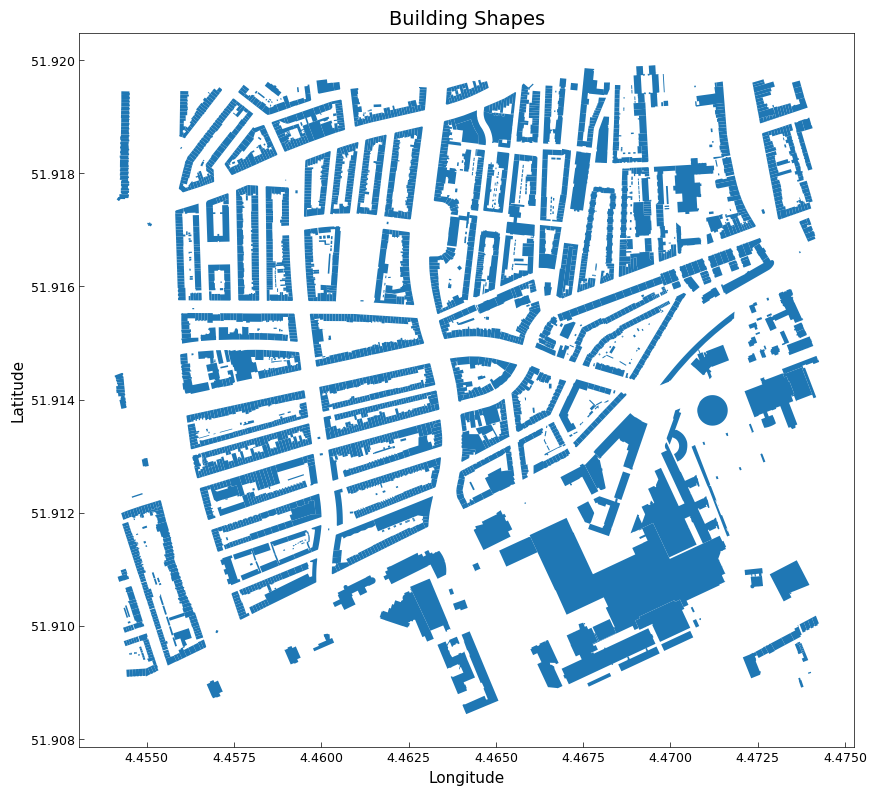

In [56]:
if not gdf.empty:

    # Set the CRS to EPSG:28992 (RD coordinate system)
    gdf.set_crs(epsg=28992, inplace=True)

    # Reproject to WGS84 (EPSG:4326)
    gdf_wgs84 = gdf.to_crs(epsg=4326)


    # Plot the geometries
    gdf_wgs84.plot(figsize =(10, 20))
    plt.title('Building Shapes')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

else:
    print("No data found in the GeoJSON file.")


# CLIP Features

In [57]:
import open3d as o3d
import numpy as np
from copy import deepcopy
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import torch
from open_clip import create_model_from_pretrained, get_tokenizer, create_model_and_transforms

In [58]:
tag = "rotterdam-siglip-more-data-corrupted" # "brooklyn-bridge-new" #
model_type = "siglip"
crop_type = "highlight" #"full"

In [59]:
pcd, features, pcd_lat, pcd_lon = load_pcd_and_features(tag, crop_type)
model, tokenizer, encode_text = get_encode_fn(model_type=model_type)

(1000000, 4, 1152) (1000000, 3)
No coord ref found


c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Age of building zero-shot prediction

In [60]:
# queries_age = ["historic building", "old house", "building constructed before 1950",
#                "traditional architecture", "contemporary architecture",
#                "recently build house",  "new house", "Building constructed after 1950"]
# # bad, ok, terrible, terrible, terrible, terrible, terrible, terrible
# queries_age = ["old house", "this house as been designed in an old school style", "last century architecture",  "modern architecture", 
#                 "modern house style", "This building is very modern"]
# # ok, bit worse, terrible, tinly selection for new, same, little less, reasonable, 
# queries_age = ["old house", "traditional housing district",   "modern architecture", "Modern housing district",
#                  "This building is very modern", "Newly constructed building with minimalist design",
#                  "21st-century architecture with clean lines and open spaces", "Modern building with innovative design",
#                  "house built after world war II"]
# # ok, no, no, no, yes!!!!!(This building is very modern), no, no,no, ..
# queries_age = ["old house", "this house as been designed in an old school style",
#                "old school house", "old school architecture",
#                "This building is very modern",]
#
queries_age = ["old building", "old house", "modern building", "modern house"]

#queries_age = ["house", "building",]

query_embed_age = encode_text(queries_age, model, tokenizer)
sim_age = features @ query_embed_age
sim_age = sim_age.max(axis=1)
sim_norm_age = np.exp(sim_age) / np.exp(sim_age).sum(-1, keepdims=True)
print(sim_age.shape)

#sim_ratio = sim_age[:, :3].sum(axis=1) / sim_age[:, 3:].sum(axis=1)
#visualize(sim_ratio, "old / new ratio")

# for i, query in enumerate(queries_age):
#     visualize(pcd, sim_norm_age[:,i], query, normalize=False)
feature = sim_norm_age[:,2:].sum(axis=-1) # sim_norm_age[:,1], sim_ratio
visualize(pcd, feature, "feature used")

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


(1000000, 4)


In [61]:
'''
queries_age = ["historic building", "old house", "traditional architecture", "modern building", "contemporary architecture", "new house", "house", "tree", "road", "grass"]
query_embed_age = encode_text(queries_age, model, tokenizer)
sim_age = features @ query_embed_age
sim_age = sim_age.max(axis=1)
sim_norm_age = np.exp(sim_age) / np.exp(sim_age).sum(-1, keepdims=True)
print(sim_age.shape)

sim_ratio = sim_age[:, :3].sum(axis=1) / sim_age[:, 3:].sum(axis=1)
visualize(sim_ratio, "old / new ratio")
'''

'\nqueries_age = ["historic building", "old house", "traditional architecture", "modern building", "contemporary architecture", "new house", "house", "tree", "road", "grass"]\nquery_embed_age = encode_text(queries_age, model, tokenizer)\nsim_age = features @ query_embed_age\nsim_age = sim_age.max(axis=1)\nsim_norm_age = np.exp(sim_age) / np.exp(sim_age).sum(-1, keepdims=True)\nprint(sim_age.shape)\n\nsim_ratio = sim_age[:, :3].sum(axis=1) / sim_age[:, 3:].sum(axis=1)\nvisualize(sim_ratio, "old / new ratio")\n'

# Correlate 

In [62]:
gdf = gpd.read_file(os.path.join(data_dir, "rotterdam.geojson"))
gdf.set_crs(epsg=28992, inplace=True)#houses
gdf['building_age'] = gdf['oorspronkelijkbouwjaar']
gdf = gdf.to_crs(epsg=4326)
gdf.head()

,id,fid,b3_dd_id,identificatie,b3_pand_deel_id,b3_h_50p,b3_h_70p,b3_h_max,b3_h_min,b3_bag_bag_overlap,...,status,tijdstipeindregistratielv,tijdstipinactief,tijdstipinactieflv,tijdstipnietbaglv,tijdstipregistratie,tijdstipregistratielv,voorkomenidentificatie,geometry,building_age
0,lod12.5793972,5793972,0,NL.IMBAG.Pand.0599100000639499,0,9.331596,9.595734,10.474796,6.963517,0.0,...,Pand in gebruik,None,None,None,None,2015-10-12 13:46:47+00:00,2015-10-12 14:00:28+00:00,2,"POLYGON ((4.45822 51.91602, 4.45805 51.91602, ...",1903
1,lod12.5794463,5794463,0,NL.IMBAG.Pand.0599100000672092,0,12.400835,13.255198,14.352334,10.249964,0.0,...,Pand in gebruik,None,None,None,None,2015-10-16 16:19:34+00:00,2015-10-16 16:30:12+00:00,2,"POLYGON ((4.45890 51.91552, 4.45882 51.91552, ...",1902
2,lod12.5804853,5804853,0,NL.IMBAG.Pand.0599100000650793,0,11.477911,13.633970,14.141188,2.810651,0.0,...,Pand in gebruik,None,None,None,None,2015-10-17 11:38:55+00:00,2015-10-17 12:00:07+00:00,2,"POLYGON ((4.47405 51.91885, 4.47404 51.91884, ...",1984
3,lod12.5794080,5794080,0,NL.IMBAG.Pand.0599100000761577,0,12.339454,12.351391,12.369716,8.885713,0.0,...,Pand in gebruik,None,None,None,None,2015-10-16 23:02:43+00:00,2015-10-16 23:30:06+00:00,2,"POLYGON ((4.45834 51.91171, 4.45840 51.91159, ...",1991
4,lod12.5794852,5794852,0,NL.IMBAG.Pand.0599100000670155,0,12.103424,12.669908,13.142063,8.699863,0.0,...,Pand in gebruik,None,None,None,None,2016-07-13 11:15:19+00:00,2016-07-13 11:30:59+00:00,3,"POLYGON ((4.46513 51.91354, 4.46534 51.91358, ...",1895


In [63]:
predicted_building_age = coord_to_geopandas(pcd_lat, pcd_lon, {"age_ratio": feature}, resample_to_regular_grid=True)
joined_gdf = aggregate_by_region(gdf.to_crs(epsg=4326), predicted_building_age, prefix="pred_", project_on="points")

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
joined_gdf_nonzero = joined_gdf[joined_gdf["pred_n_points"] > 0]
correlation = joined_gdf_nonzero['building_age'].corr(joined_gdf_nonzero['age_ratio'], method='spearman')# spearman, pearson
correlation

0.5812615570339256

In [ ]:
joined_gdf_per_building = aggregate_by_region(gdf.to_crs(epsg=4326), predicted_building_age, prefix="pred_", project_on="regions")

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:97: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averages = grouped.mean()


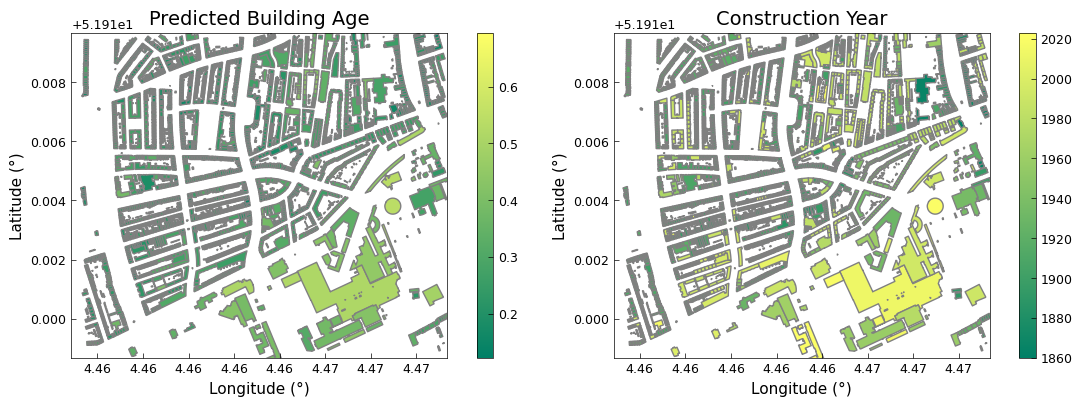

In [ ]:
from visualization_utils import set_matplotlib_defaults
set_matplotlib_defaults()

fig, ax = plt.subplots(1, 2, figsize=(14 / 1.2, 5 / 1.2), tight_layout=True)
fig.patch.set_facecolor('white')
ax[0].set_facecolor('white')

lon_min, lon_max = pcd_lon.min(), pcd_lon.max()
lat_min, lat_max = pcd_lat.min(), pcd_lat.max()

# plt.xticks(rotation=45)
joined_gdf_per_building.plot(column='pred_avg_age_ratio', ax=ax[0], legend=True,
             cmap="summer", edgecolor='gray')
ax[0].set_xlim([lon_min, lon_max])
ax[0].set_ylim([lat_min, lat_max]) 
ax[0].set_title('Predicted Building Age')
ax[0].set_xlabel('Longitude (°)')
ax[0].set_ylabel('Latitude (°)')
# plt.ticklabel_format(scilimits=(-5, 8), useOffset=False)
# rotate xticks
# ax[0].set_xticks(ax[0].get_xticks()[1::2], labels=[f"{x:,.3f}" for x in ax[0].get_xticks()[1::2]], rotation=45)
# ax[0].set_yticks(ax[0].get_yticks()[1::2], labels=[f"{y:,.2f}" for y in ax[0].get_yticks()[1::2]])

ax[1].set_facecolor('white')
gdf.plot(column='building_age', ax=ax[1], legend=True,
             cmap="summer", edgecolor='gray')
ax[1].set_xlim([lon_min, lon_max])
ax[1].set_ylim([lat_min, lat_max]) 
ax[1].set_title('Construction Year')
ax[1].set_xlabel('Longitude (°)')
ax[1].set_ylabel('Latitude (°)')

from matplotlib.ticker import FormatStrFormatter


ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# ax[1].set_xticks(ax[1].get_xticks()[1::2], labels=[f"{x:,.3f}" for x in ax[1].get_xticks()[1::2]], rotation=45)
# ax[1].set_yticks(ax[1].get_yticks()[1::2], labels=[f"{y:,.2f}" for y in ax[1].get_yticks()[1::2]])

# plt.xticks(rotation=45)
fig.savefig("building_age.png", dpi=1200)
# plt.suptitle(f'Predicted vd Heatmap of Point Density, Correlation: {correlation:.3f}')
plt.show()

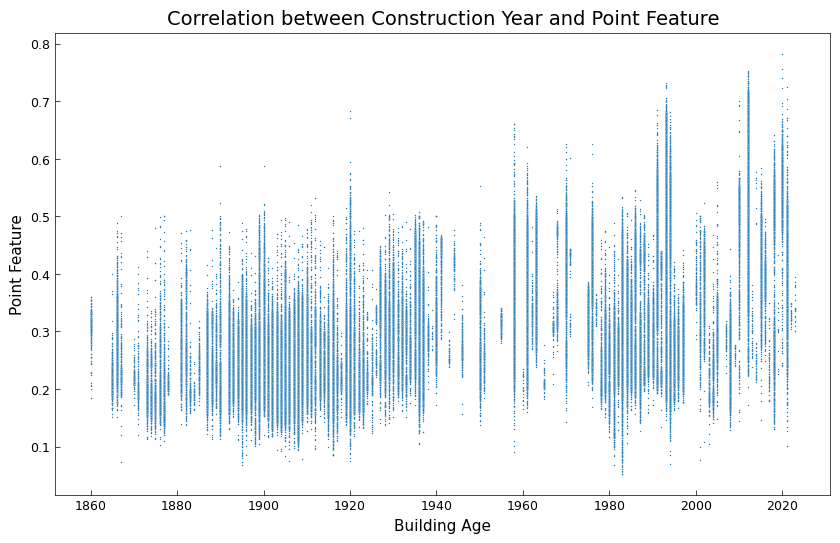

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
joined_gdf_non_nan = joined_gdf_nonzero[joined_gdf_nonzero['building_age'].notnull() & joined_gdf_nonzero['age_ratio'].notnull()]
sns.scatterplot(x=joined_gdf_non_nan['building_age'], y=joined_gdf_non_nan['age_ratio'], s=1)
plt.title('Correlation between Construction Year and Point Feature')
plt.xlabel('Building Age')
plt.ylabel('Point Feature')
plt.show()


## presence of building

In [ ]:
queries_is_building = ["building", "tree", "road", "park", "river", "car", "sea / lake / canal", "urban scene", "parking lot", "city"]

#queries_age = ["house", "building",]

query_embed_building = encode_text(queries_is_building, model, tokenizer)
sim_building = features @ query_embed_building
sim_building = sim_building.max(axis=1)
sim_norm_building = np.exp(sim_building) / np.exp(sim_building).sum(-1, keepdims=True)
print(sim_building.shape)

#sim_ratio = sim_age[:, :3].sum(axis=1) / sim_building[:, 3:].sum(axis=1)
#visualize(sim_ratio, "old / new ratio")

# for i, query in enumerate(queries_age):
#     visualize(pcd, sim_norm_age[:,i], query, normalize=False)
feature_building = sim_norm_building[:,0]# sim_norm_age[:,1], sim_ratio
visualize(pcd, feature_building, "feature used")

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


(500000, 10)


In [ ]:
predicted_is_building = coord_to_geopandas(pcd_lat, pcd_lon, {"building_prob": feature_building}, resample_to_regular_grid=True)
joined_gdf_is_building = aggregate_by_region(gdf.to_crs(epsg=4326), predicted_is_building, prefix="pred_", project_on="points")

c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:85: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pcd_points_gpd["geometry"] = pcd_points_gpd.apply(lambda row: Point(row['long'], row['lat']), axis=1)
c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Best threshold: 0.566, Best accuracy: 0.877
Confusion matrix: 
building_prob   False   True 
building_age                 
False          625100   71176
True            51611  249563
True positives: [625100 249563], False positives: building_prob
False    51611
True     71176
dtype: int64, True negatives: building_prob
False    249563
True     625100
dtype: int64, False negatives: building_age
False    71176
True     51611
dtype: int64


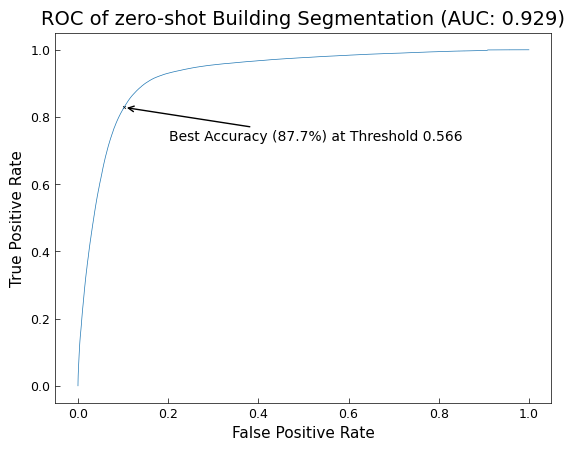

In [ ]:
from sklearn import metrics
import pandas as pd
joined_gdf_is_building_notna = joined_gdf_is_building[joined_gdf_is_building['building_prob'].notnull()]
y_true = joined_gdf_is_building_notna['building_age'].notnull()
y_pred = joined_gdf_is_building_notna['building_prob']
fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred)
auc = metrics.roc_auc_score(y_true, y_pred)
best_accuracy, best_threshold = 0, 0
for threshold in np.linspace(0, 1, 100):
    y_pred_thresholded = y_pred > threshold
    accuracy = metrics.accuracy_score(y_true, y_pred_thresholded)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

confusion_matrix = pd.crosstab(y_true, y_pred > best_threshold)
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)
FPR = FP[1] / (FP[1] + TN[1])
TPR = TP[1] / (TP[1] + FN[1])

print(f"Best threshold: {best_threshold:.3f}, Best accuracy: {best_accuracy:.3f}")
print(f"Confusion matrix: \n{confusion_matrix}")
print(f"True positives: {TP}, False positives: {FP}, True negatives: {TN}, False negatives: {FN}")

plt.plot(fpr,tpr)
plt.scatter([FPR],[TPR], marker='x', color='black')
plt.title(f"ROC of zero-shot Building Segmentation (AUC: {auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.annotate(
# Label and coordinate
f"Best Accuracy ({100*best_accuracy:.1f}%) at Threshold {best_threshold:.3f}", xy=(FPR, TPR),xytext=(FPR+0.1, TPR-0.1) ,
horizontalalignment="left",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=1)
)

# plt.legend(loc=4)
plt.show()

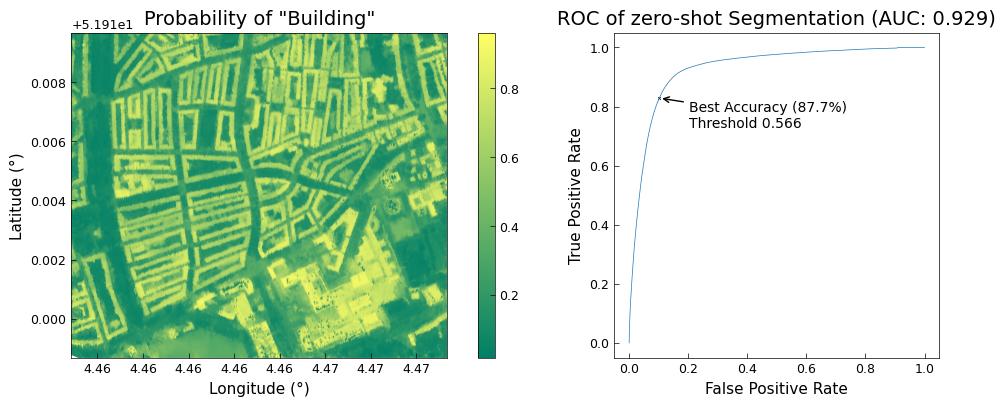

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14 / 1.2, 5 / 1.2), tight_layout=True)
fig.patch.set_facecolor('white')
ax[0].set_facecolor('white')

lon_min, lon_max = pcd_lon.min(), pcd_lon.max()
lat_min, lat_max = pcd_lat.min(), pcd_lat.max()

joined_gdf_is_building.plot(column='building_prob', legend=True, cmap="summer", s=0.01, ax=ax[0])
ax[0].set_xlim([lon_min, lon_max])
ax[0].set_ylim([lat_min, lat_max]) 
ax[0].set_title('Probability of "Building"')
ax[0].set_xlabel('Longitude (°)')
ax[0].set_ylabel('Latitude (°)')
# plt.ticklabel_format(scilimits=(-5, 8), useOffset=False)
# rotate xticks
# ax[0].set_xticks(ax[0].get_xticks()[1::2], labels=[f"{x:,.3f}" for x in ax[0].get_xticks()[1::2]], rotation=45)
# ax[0].set_yticks(ax[0].get_yticks()[1::2], labels=[f"{y:,.2f}" for y in ax[0].get_yticks()[1::2]])

ax[1].plot(fpr,tpr)
ax[1].scatter([FPR],[TPR], marker='x', color='black')
ax[1].set_title(f"ROC of zero-shot Segmentation (AUC: {auc:.3f})")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")

ax[1].annotate(
# Label and coordinate
f"Best Accuracy ({100*best_accuracy:.1f}%) \nThreshold {best_threshold:.3f}", xy=(FPR, TPR),xytext=(FPR+0.1, TPR-0.1) ,
horizontalalignment="left",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=1)
)
# set aspect equal
ax[1].set_aspect('equal', 'box')
# ax[0].set_aspect('equal', 'box')
# plt.suptitle(f'Predicted vd Heatmap of Point Density, Correlation: {correlation:.3f}')
# save as pdf 

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.savefig("building_segmentation.png", dpi=1200)
plt.show()

## Building age: few-shot learning

In [ ]:
embedding_gdf = coord_to_geopandas(pcd_lat, pcd_lon, {"embeddings": list(features)}, resample_to_regular_grid=False)
embeddings_per_building = aggregate_by_region(gdf.to_crs(epsg=4326), embedding_gdf, prefix="pred_", project_on="regions")
embeddings_per_building = embeddings_per_building[embeddings_per_building["pred_n_points"] > 0]

c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:85: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pcd_points_gpd["geometry"] = pcd_points_gpd.apply(lambda row: Point(row['long'], row['lat']), axis=1)
c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:97: FutureWarning: The default value

In [ ]:
train_df = embeddings_per_building.sample(frac=0.3, random_state=42)
test_df = embeddings_per_building.drop(train_df.index)

train_X = np.concatenate([x for x in train_df['pred_embeddings'].to_list() if isinstance(x, list) and len(x) > 0], axis=0)
train_y = np.concatenate([[age for _ in range(len(x))] for x, age in zip(train_df['pred_embeddings'].to_list(), train_df["building_age"].to_list()) if isinstance(x, list) and len(x) > 0], axis=0)

test_X = np.concatenate([x for x in test_df['pred_embeddings'].to_list() if isinstance(x, list) and len(x) > 0], axis=0)
test_y = np.concatenate([[age for _ in range(len(x))] for x, age in zip(test_df['pred_embeddings'].to_list(), test_df["building_age"].to_list()) if isinstance(x, list) and len(x) > 0], axis=0)

if len(test_X) > 20000:
    np.random.seed(42) 
    random_indices = np.random.choice(len(test_X), 20000, replace=False)
    test_X = test_X[random_indices]
    test_y = test_y[random_indices]
    
print(test_X.shape, test_y.shape)
print(train_X.shape, train_y.shape)

(20000, 4, 1152) (20000,)
(35356, 4, 1152) (35356,)


In [64]:
from sklearn.neighbors import KNeighborsRegressor

pred_mode = "flatten_and_mean"
if pred_mode == "flatten_and_mean":
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(train_X.reshape((train_X.shape[0]*train_X.shape[1], -1)), np.stack([train_y for _ in range(train_X.shape[1])], axis=1).flatten())
    y_pred = np.mean([knn.predict(test_X[:,i]) for i in range(test_X.shape[1])], axis=0)
elif pred_mode == "finest":
    knn = KNeighborsRegressor(n_neighbors=50)
    knn.fit(train_X[:,0], train_y)
    y_pred = knn.predict(test_X[:,0])
elif pred_mode == "closest":
    knns = [KNeighborsRegressor(n_neighbors=5) for _ in range(train_X.shape[1])]
    y_pred, distances = [], []
    for i, knn in enumerate(knns):
        knn.fit(train_X[:,i], train_y)
        y_pred.append(knn.predict(test_X[:,i]))
        distances.append(knn.kneighbors(test_X[:,i], return_distance=True)[1])
    y_pred = np.array(y_pred)
    best_ixes = np.array(distances).mean(axis=-1).argmin(axis=0)
    y_pred = np.array([y_pred[i] for i in best_ixes])


In [65]:
test_y.shape, y_pred.shape, len(test_df), len(train_df), len(embeddings_per_building)

((20000,), (20000,), 2093, 897, 2990)

In [66]:
# eval
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

print(f"Mean squared error: {mean_squared_error(test_y, y_pred):.2f}")
print(f"R2 score: {r2_score(test_y, y_pred):.2f}")
print(f"Spearman corr {pd.Series(test_y).corr(pd.Series(y_pred), method='spearman'):.2f}")

Mean squared error: 1054.78
R2 score: 0.51
Spearman corr 0.73
